# Machine Learning Engineer Nanodegree Capstone Project
## Toxic Comment Classification Challenge
### Identify and classify toxic online comments
#### Jeff Gerlach

### Project Setup
Here we will import the initially required libraries and import the Kaggle train and test dataset CSV files.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sb

%matplotlib inline

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
test_labels = pd.read_csv('./data/test_labels.csv')
# merge test labels with the original test dataset
test_data_final = pd.merge(test_data, test_labels, on='id')
# remove test data not used in scoring - these have labels of -1 for all toxicity subtypes
test_data_final.drop(test_data_final.loc[test_data_final['toxic']==-1].index, inplace=True)

### Dataset Analysis

Here we take a high level view of the datasets we will be working with.

First off, we check examples of the training and test data.

In [81]:
train_data.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [82]:
test_data_final.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
153142,fff69311f306df44,Balancing the two approaches to psychiatry ( b...,0,0,0,0,0,0
153144,fff7159b3ee95618,"== Your name mentioned == \n Hi, I just though...",0,0,0,0,0,0
153145,fff718ffe5f05559,I've just discovered yet another list: List of...,0,0,0,0,0,0
153147,fff83b80284d8440,::Consensus for ruining Wikipedia? I think tha...,0,0,0,0,0,0
153149,fff8f521a7dbcd47,shut down the mexican border withought looking...,0,0,0,0,0,0
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0
153156,fffb5451268fb5ba,""" \n\n == Unicorn lair discovery == \n\n Suppo...",0,0,0,0,0,0


In [83]:
print(any(train_data['id'].duplicated())) # see if id values are repeated
print(train_data.isnull().values.any()) # check for any n/a values
display(train_data.describe()) # check statistics of each classification

False
False


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
train_size = train_data.shape[0]
test_size = test_data_final.shape[0]
total_count = train_size + test_size
print(f"Number of training examples {train_size}")
print(f"Number of test examples {test_size}")
print(f"Train/Test Ratio: {round(train_size/total_count * 100, 2)}% / {round(test_size/total_count * 100, 2)}%")

Number of training examples 159571
Number of test examples 63978
Train/Test Ratio: 71.38% / 28.62%


In [86]:
# add a new column 'none' to indicate no toxicity
train_data_new = train_data.copy()
comment_category_totals=train_data.iloc[:,2:].sum(axis=1)
train_data_new['none']=(comment_category_totals==0)
print(f"Comments with no toxicity: {train_data_new['none'].sum()}")
print(f"% of total training dataset marked as not toxic: {train_data_new['none'].sum()/len(train_data_new)}")

Comments with no toxicity: 143346
% of total training dataset marked as not toxic: 0.8983211235124177


In [87]:
print(train_data_new[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']].sum())

toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
none             143346.0
dtype: float64


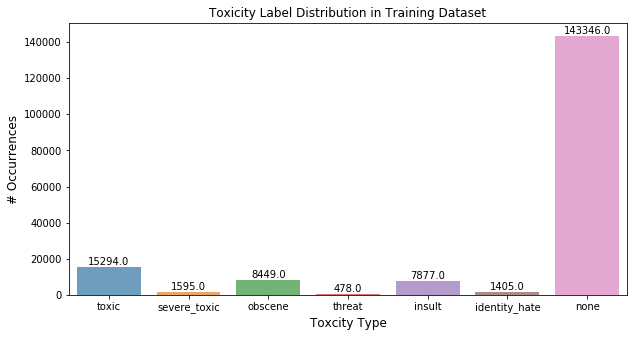

In [91]:
x_vals=train_data_new.iloc[:,2:].sum()
plt.figure(figsize=(10,5))
axes = sb.barplot(x_vals.index, x_vals.values, alpha=0.7)
plt.title("Toxicity Label Distribution in Training Dataset")
plt.ylabel('# Occurrences', fontsize=12)
plt.xlabel('Toxcity Type', fontsize=12)
rectangles = axes.patches
labels = x_vals.values
for rectangle, label in zip(rectangles, labels):
    height = rectangle.get_height()
    axes.text(rectangle.get_x() + rectangle.get_width()/2, height + 5, label, va='bottom', ha='center')
plt.show()

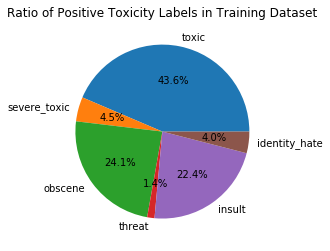

In [90]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plt.title('Ratio of Positive Toxicity Labels in Training Dataset')
plt.pie(train_data_new[labels].sum(), labels=labels, autopct='%1.1f%%')
plt.show()

In the above analysis, we notice a few things - first, the training dataset is imbalanced with regards to comment classification labels. We see that almost 90% of the comments have no toxicity label, and for the comments that are labeled as toxic, the 'toxic' comment dominates nearly half of these positive examples. While not as bad as say the perennial spam dataset example where 1% of the data is classied as spam and the rest is not spam, care will need to be taken when selecting a validation set to match the positive and negative toxicity distribution along with the toxicity subtype distributions as closely as possible to avoid skewing results. We also note that the training data is 70% of the total data, which seems typical.

### Preprocessing data

The input data that will be used to engineer and extract features is in the form of comment text. This input generally cannot be fed directly into machine learning models, and must first be converted into a large, sparse vector of numbers using tokenizing and vectorization. We will use Scikit Learn's `TfidVectorizer` function to transform the dataset documents (i.e. comments) into a matrix of TF-IDF features after splitting by both words and characters. Here we will use the combined training and test sets to make the overall word feature vector as this is not actively doing any model training, but merely generating features which will be used to train our models - there are varying opinions on this mixing of datasets, but it is allowed to take this approach in Kaggle competitions and so we will do so here for ease of processing. Default English language stopwords will be used, accents will be stripped from characters, and we will start with 1-grams and the top 10,000 words for the benchmark model. Based on [Logistic Regresion with words and char n-grams](https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams).

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# combine training and test comments so we have the entire corpus of words and characters for vectorization
combined_comments = pd.concat([train_data['comment_text'], test_data_final['comment_text']])
word_vec = TfidfVectorizer(stop_words='english', analyzer='word', strip_accents='unicode', sublinear_tf=True,
                           token_pattern=r'\w{1,}', max_features=10000, ngram_range=(1,1))
word_vec.fit(combined_comments)
train_word_features = word_vec.transform(train_data['comment_text'])
test_word_features = word_vec.transform(test_data_final['comment_text'])

character_vec = TfidfVectorizer(analyzer='char', stop_words='english', strip_accents='unicode', sublinear_tf=True,
                               max_features=50000, ngram_range=(2,6))
character_vec.fit(combined_comments)
train_char_features = character_vec.transform(train_data['comment_text'])
test_char_features = character_vec.transform(test_data_final['comment_text'])

train_data_features = hstack([train_char_features, train_word_features])
test_data_features = hstack([test_char_features, test_word_features])

### Benchmark Model

Here we use a basic logistic regression model trained on the word and character-vectorized features above.

In [77]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

scores = []
submission = pd.DataFrame.from_dict({'id': test_data_final['id']})
for class_name in class_names:
    train_target = train_data[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_data_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_data_features, train_target)
    submission[class_name] = classifier.predict_proba(test_data_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.9697993918268214
CV score for class severe_toxic is 0.9877323751427841
CV score for class obscene is 0.9846509200683157
CV score for class threat is 0.983168843862221
CV score for class insult is 0.977893576501816
CV score for class identity_hate is 0.9743483066936713
Total CV score is 0.9795989023492715


In [79]:
submission.to_csv('benchmark_submission.csv', index=False) # convert to file for Kaggle submission
from sklearn.metrics import roc_auc_score
def test_score(predicted_vals):
    '''Actual Kaggle competion score using test set labels provided after competition close'''
    actuals = test_labels.copy()
    actuals.drop(actuals.loc[actuals['toxic']==-1].index, inplace=True)
    scores_test = []
    for class_name in class_names:
        score = roc_auc_score(actuals[class_name], predicted_vals[class_name])
        scores_test.append(score)
    print('Test set score is {}'.format(np.mean(scores_test)))

test_score(submission)

Test set score is 0.9764853663137982


We see that with the appropriate features, even a basic model can achieve very good performance - an averaged 97.6% ROC AUC score for each of the classification labels. 

### Capstone Model

Here we will develop a neural network architecture to try and achieve better performance that the logistic regression benchmark model utilized above. The goal will be to implement a Capsule net using GRU with a pretrained word embedding. The framework for this was referenced from the ["Capsule net with GRU"](https://www.kaggle.com/chongjiujjin/capsule-net-with-gru), with tweaks made to the embedding, test/train split, and parameters used to achieve higher ROC AUC.

In [48]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # Mac OS X bug
from keras.layers import Dense, Input, Bidirectional, Activation, Conv1D, GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print(os.listdir("./input"))

['.DS_Store', 'crawl-300d-2M.vec', 'glove.840B.300d.txt']


In [50]:
EMBEDDING_FILE = './input/crawl-300d-2M.vec'
train= pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train["comment_text"].fillna("fillna")
test["comment_text"].fillna("fillna")
X_train = train["comment_text"].str.lower()
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

X_test = test["comment_text"].str.lower()

In [51]:
max_features=100000
maxlen=200
embed_size=300

In [52]:
# Evaluation function based on Kaggle competition metric for optimization
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [53]:
# Tokenize comments and pad to max length so all inputs are the same size
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [54]:
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [55]:
# create the embedding matrix from the Facebook crawl dataset
word_index = tok.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size)) # set not found words to vector of zeros in embedding
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [56]:
from keras.layers import K, Activation
from keras.engine import Layer
from keras.layers import Dense, Input, Embedding, Dropout, Bidirectional, GRU, Flatten, SpatialDropout1D
gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
dropout_p = 0.25
rate_drop_dense = 0.28

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


def get_model():
    input1 = Input(shape=(maxlen,))
    embed_layer = Embedding(max_features,
                            embed_size,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=False)(input1)
    embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)
    
    x = Bidirectional(
        GRU(gru_len, activation='relu', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True))(
        embed_layer)
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
    output = Dense(6, activation='sigmoid')(capsule)
    model = Model(inputs=input1, outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    model.summary()
    return model

In [57]:
from skmultilearn.model_selection import iterative_train_test_split

model = get_model()

batch_size = 256
epochs = 3
# utilize stratified sampling to improve model training and accuracy
X_tra, y_tra, X_val, y_val = iterative_train_test_split(x_train, y_train, test_size=0.05)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          329472    
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            40960     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
___________________________

In [58]:
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 151592 samples, validate on 7979 samples
Epoch 1/3
151592/151592 [==============================] - 1431s 9ms/step - loss: 0.0797 - acc: 0.9766 - val_loss: 0.0460 - val_acc: 0.9830

 ROC-AUC - epoch: 1 - score: 0.978652
Epoch 2/3
151592/151592 [==============================] - 1440s 10ms/step - loss: 0.0491 - acc: 0.9819 - val_loss: 0.0464 - val_acc: 0.9823

 ROC-AUC - epoch: 2 - score: 0.985561
Epoch 3/3
151592/151592 [==============================] - 1423s 9ms/step - loss: 0.0451 - acc: 0.9829 - val_loss: 0.0417 - val_acc: 0.9836

 ROC-AUC - epoch: 3 - score: 0.987699


In [59]:
model.save_weights('new_model_2.hdf5')
y_pred = model.predict(x_test, batch_size=1024, verbose=1)

153164/153164 [==============================] - 437s 3ms/step


In [64]:
submission_new = pd.read_csv('./data/sample_submission.csv')
submission_new[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission_new.to_csv('submission_new_2.csv', index=False)
test_score(submission_new.drop(submission_new.loc[pd.merge(test_data, test_labels, on='id')['toxic']==-1].index))

Test set score is 0.981477524354104


We see fairly good results here, but we will attempt to try a method known as ensembling to improve the accuracy on the test set even more. The basic approach is to combine the output from several models together (one way would be to average the probabilities) - the less correlated the models are (i.e. the more different they are in their approach), the better results you will generally see. Next I will implement a Pooled Gated Recurrent Unit (GRU) network, and averge the results with both the baseline logistic regression and CapsuleNet models to create a final ensemble result to see if we get increased predictive power on the final output.

First we build and train and run predictions with the GRU network, referenced from ["Bidirectional GRU with Convolution"](https://www.kaggle.com/eashish/bidirectional-gru-with-convolution):

In [65]:
sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(6, activation="sigmoid")(x)
gru_model = Model(sequence_input, preds)
gru_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [67]:
batch_size = 128
epochs = 4
# Use stratified sampling again
X_tra, y_tra, X_val, y_val = iterative_train_test_split(x_train, y_train, test_size=0.1)

In [68]:
checkpoint = ModelCheckpoint("gru_model.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]

In [192]:
gru_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     30000000    input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 200, 300)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 256)     329472      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

In [69]:
gru_model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
gru_model.load_weights("gru_model.hdf5")
y_pred_gru = gru_model.predict(x_test,batch_size=1024,verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 1842s 13ms/step - loss: 0.0571 - acc: 0.9798 - val_loss: 0.0444 - val_acc: 0.9830

 ROC-AUC - epoch: 1 - score: 0.987243

Epoch 00001: val_acc improved from -inf to 0.98301, saving model to gru_model.hdf5
Epoch 2/4
143613/143613 [==============================] - 1964s 14ms/step - loss: 0.0435 - acc: 0.9833 - val_loss: 0.0419 - val_acc: 0.9837

 ROC-AUC - epoch: 2 - score: 0.988575

Epoch 00002: val_acc improved from 0.98301 to 0.98368, saving model to gru_model.hdf5
Epoch 3/4
143613/143613 [==============================] - 1818s 13ms/step - loss: 0.0411 - acc: 0.9841 - val_loss: 0.0412 - val_acc: 0.9840

 ROC-AUC - epoch: 3 - score: 0.989231

Epoch 00003: val_acc improved from 0.98368 to 0.98401, saving model to gru_model.hdf5
Epoch 4/4
143613/143613 [==============================] - 1848s 13ms/ste

In [71]:
submission_new_3 = pd.read_csv('./data/sample_submission.csv')
submission_new_3[class_names] = y_pred_gru
submission_new_3.to_csv('submission_new_3.csv', index=False)
test_score(submission_new_3.drop(submission_new_3.loc[pd.merge(test_data, test_labels, on='id')['toxic']==-1].index))

Test set score is 0.9829294418396707


Finally we ensemble the three different models by averaging their predicted probabilities for each row in the test set together (there are more complicated methods of stacking and blending models together, but some research shows that simple averaging can gain appreciable increases in overall model predictive performance that is much more production-viable in terms of time to process new input data):

In [95]:
benchmark_preds = submission
capsnet_preds = submission_new
gru_preds = submission_new_3
ensemble_preds = benchmark_preds.copy()
ensemble_preds[class_names] = (benchmark_preds[class_names] + capsnet_preds[class_names] + gru_preds[class_names]) / 3
ensemble_preds.to_csv('ensemble_submission.csv', index=False) # create submission deliverable
test_score(ensemble_preds.drop(ensemble_preds.loc[pd.merge(test_data, test_labels, on='id')['toxic']==-1].index))

Test set score is 0.984155859603041


### Results

After first implementing a CapsuleNet architecture, I used the standard `test_train_split` sklearn method to create training and validation sets. This model was able to achieve a validation score of ` 0.973554` after 1 epoch (which took me about an hour to run) and a test set score of `0.966448` - again, the scoring is the average of the ROC AUC for all 6 classes. I then reset the model and trained it again, this time using the `iterative_train_test_split` from the scikit-multilearn package to keep the toxicity labels evenly distributed between training and validation sets. This bumped the CapsNet model first epoch validation score to `0.9830`, a nearly 1% imporovement, so I decided to use this method. After full training, the test score was `0.9815`, a `0.015` improvement which at these high levels is quite significant.

While this result makes the model quite viable for the task at hand, when it comes to Kaggle competitions, every tiny increase in performance can translate to large jumps on the leaderboard, so I wanted to see if I could do even better. After some research, I found that ensembling methods, where results from multiple models are combined (think of random forests), is usually a promising approach to improve performance. So after skimming through some of the higher performing models that were submitted, I decided to also implement a Pooled Gated Recurrent Unit (GRU) network and then average the 3 model's predicted probabilities for each test comment and see the final combined performance. The table below shows the individual and combined performances:

| model               | Test set ROC AUC score |
|---------------------|------------------------|
| Logistic Regression | 0.9765                 |
| CapsuleNet          | 0.9815                 |
| Pooled GRU          | 0.9829                 |
| Ensemble            | 0.9842                 |

This end score is within 0.0044 of the top submission (0.98856) in the competition, and good enough to place in the top third of submissions (as can be seen, there is intense competition to get those last few decimal places). Further tweaking of the models, more training epochs, and addition of more models into the ensemble would no doubt improve performance of my model further.

The final product is a CSV file that could be submitted for scoring in the Kaggle competition, with predicted probabilities of each toxicity classification (assuming 0.5 or over is a positive label):

In [96]:
ensemble_preds.tail(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153142,fff69311f306df44,0.023293,0.001988,0.007768,0.001021,0.009774,0.003242
153144,fff7159b3ee95618,0.022855,0.001967,0.008148,0.001492,0.010687,0.002807
153145,fff718ffe5f05559,0.008101,0.001126,0.003697,0.000746,0.004281,0.001944
153147,fff83b80284d8440,0.026423,0.001683,0.006553,0.000918,0.007654,0.001963
153149,fff8f521a7dbcd47,0.632408,0.013092,0.168436,0.004752,0.114637,0.017151
153150,fff8f64043129fa2,0.003220,0.000719,0.002141,0.000724,0.002007,0.001032
153151,fff9d70fe0722906,0.607600,0.014873,0.333263,0.004693,0.336115,0.009291
153154,fffa8a11c4378854,0.636889,0.010771,0.081551,0.006263,0.174566,0.177566
153155,fffac2a094c8e0e2,0.952921,0.138994,0.884936,0.013073,0.811505,0.158881
153156,fffb5451268fb5ba,0.017726,0.001551,0.007013,0.000941,0.006229,0.002169


And visualizations of the ROC curves for the final (ensembled) model submission for each toxicity label - the area under these curves are averaged for the overall score in the competition:

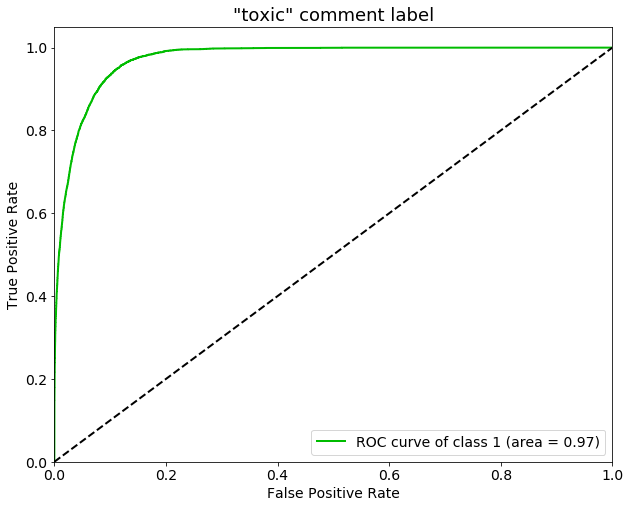

In [174]:
import scikitplot as skplot
ground_truth = test_labels.copy()
ground_truth.drop(ground_truth.loc[ground_truth['toxic']==-1].index, inplace=True)
ground_truth=ground_truth[ground_truth.columns[-6:]]
predicted = ensemble_preds[ensemble_preds.columns[-6:]]
# toxic label ROC curve
y_pred_probs = predicted['toxic'].values.reshape(-1,1)
y_pred_probs = np.concatenate((1-y_pred_probs, y_pred_probs), axis=1)
truth = ground_truth['toxic'].values.reshape(-1,1)
skplot.metrics.plot_roc(truth, y_pred_probs, '"toxic" comment label', plot_micro=False,
                        plot_macro=False, classes_to_plot=[1], figsize=(10,8), title_fontsize=18,
                        text_fontsize=14)

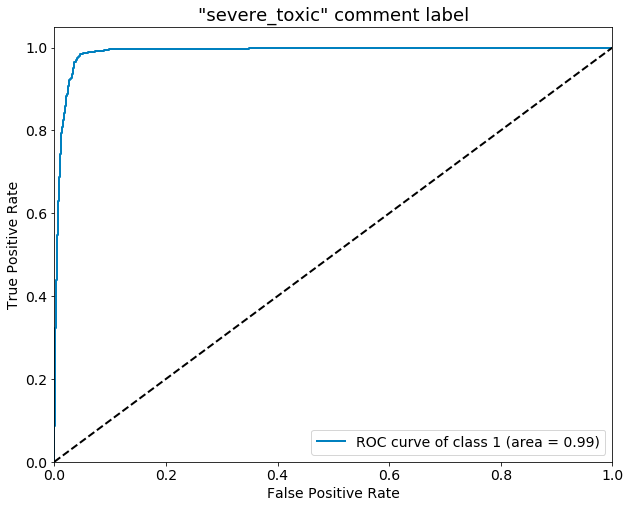

In [177]:
# severe_toxic label ROC curve
y_pred_probs = predicted['severe_toxic'].values.reshape(-1,1)
y_pred_probs = np.concatenate((1-y_pred_probs, y_pred_probs), axis=1)
truth = ground_truth['severe_toxic'].values.reshape(-1,1)
skplot.metrics.plot_roc(truth, y_pred_probs, '"severe_toxic" comment label', plot_micro=False,
                        plot_macro=False, classes_to_plot=[1], figsize=(10,8), title_fontsize=18,
                        text_fontsize=14, cmap="winter")

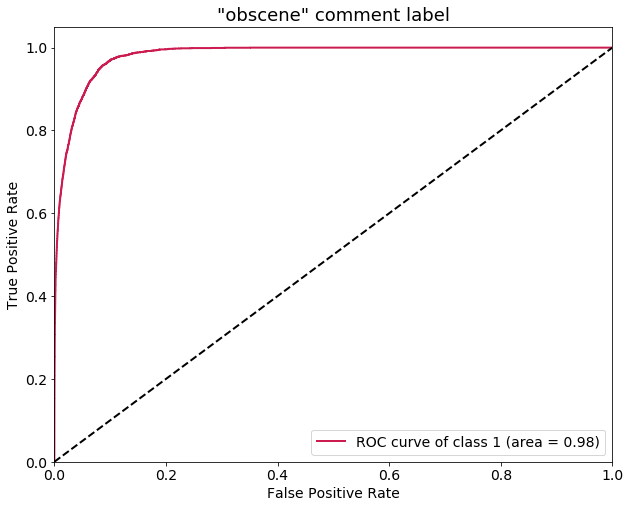

In [179]:
# obscene label ROC curve
y_pred_probs = predicted['obscene'].values.reshape(-1,1)
y_pred_probs = np.concatenate((1-y_pred_probs, y_pred_probs), axis=1)
truth = ground_truth['obscene'].values.reshape(-1,1)
skplot.metrics.plot_roc(truth, y_pred_probs, '"obscene" comment label', plot_micro=False,
                        plot_macro=False, classes_to_plot=[1], figsize=(10,8), title_fontsize=18,
                        text_fontsize=14, cmap="rocket")

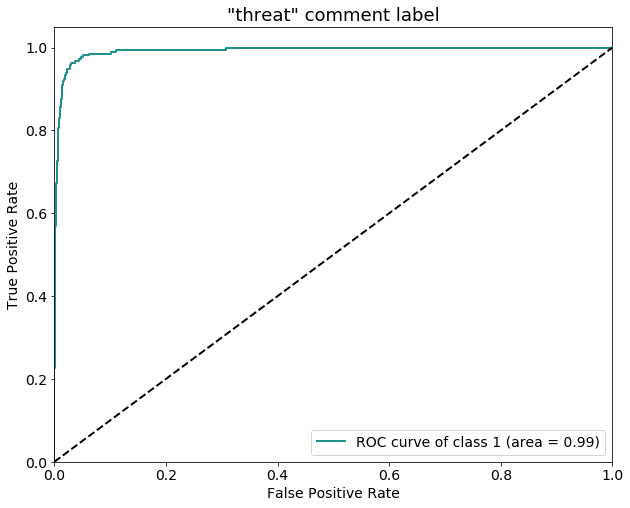

In [181]:
# threat label ROC curve
y_pred_probs = predicted['threat'].values.reshape(-1,1)
y_pred_probs = np.concatenate((1-y_pred_probs, y_pred_probs), axis=1)
truth = ground_truth['threat'].values.reshape(-1,1)
skplot.metrics.plot_roc(truth, y_pred_probs, '"threat" comment label', plot_micro=False,
                        plot_macro=False, classes_to_plot=[1], figsize=(10,8), title_fontsize=18,
                        text_fontsize=14, cmap="viridis")

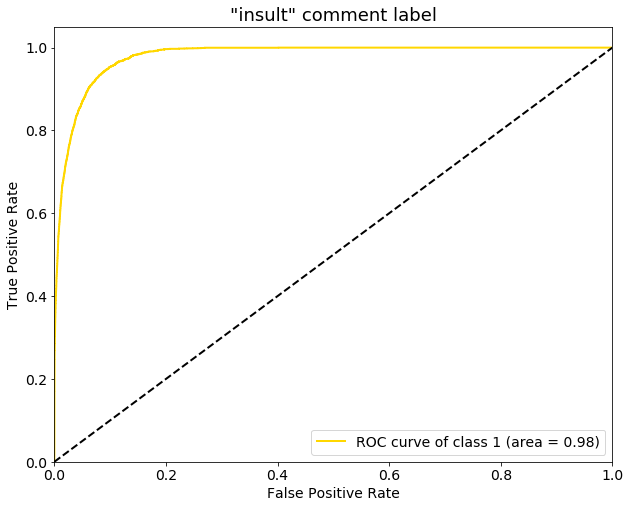

In [183]:
# insult label ROC curve
y_pred_probs = predicted['insult'].values.reshape(-1,1)
y_pred_probs = np.concatenate((1-y_pred_probs, y_pred_probs), axis=1)
truth = ground_truth['insult'].values.reshape(-1,1)
skplot.metrics.plot_roc(truth, y_pred_probs, '"insult" comment label', plot_micro=False,
                        plot_macro=False, classes_to_plot=[1], figsize=(10,8), title_fontsize=18,
                        text_fontsize=14, cmap="prism")

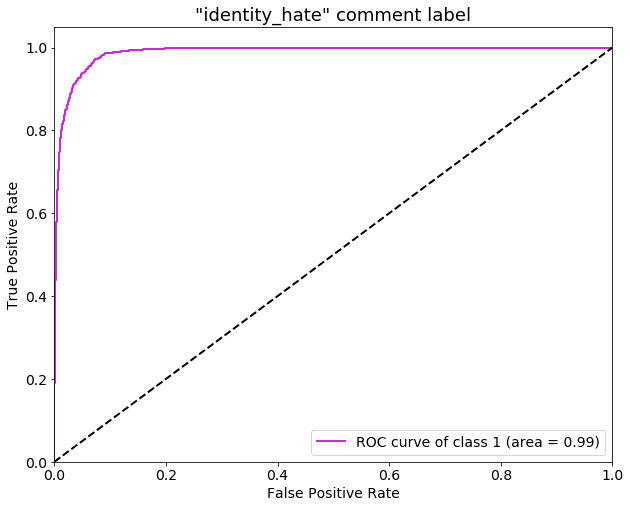

In [190]:
# identity_hate label ROC curve
y_pred_probs = predicted['identity_hate'].values.reshape(-1,1)
y_pred_probs = np.concatenate((1-y_pred_probs, y_pred_probs), axis=1)
truth = ground_truth['identity_hate'].values.reshape(-1,1)
skplot.metrics.plot_roc(truth, y_pred_probs, '"identity_hate" comment label', plot_micro=False,
                        plot_macro=False, classes_to_plot=[1], figsize=(10,8), title_fontsize=18,
                        text_fontsize=14, cmap="gnuplot2")